Using device: cpu

Initialized 5 PartyModels for Standard VFL with embedding_dim=32

Initialized 5 PartyModels for Inference-Only Sharing VFL with embedding_dim=32

Initialized AggregatorModels for both methods.

=== Training Standard VFL ===

Training PartyModel 1/5...
  Epoch [1/5], Loss: 2.2635
  Epoch [2/5], Loss: 2.1985
  Epoch [3/5], Loss: 2.1897
  Epoch [4/5], Loss: 2.1834
  Epoch [5/5], Loss: 2.1753

Training PartyModel 2/5...
  Epoch [1/5], Loss: 1.0526
  Epoch [2/5], Loss: 0.7694
  Epoch [3/5], Loss: 0.7175
  Epoch [4/5], Loss: 0.6952
  Epoch [5/5], Loss: 0.6767

Training PartyModel 3/5...
  Epoch [1/5], Loss: 0.5021
  Epoch [2/5], Loss: 0.2735
  Epoch [3/5], Loss: 0.2434
  Epoch [4/5], Loss: 0.2213
  Epoch [5/5], Loss: 0.2088

Training PartyModel 4/5...
  Epoch [1/5], Loss: 0.5878
  Epoch [2/5], Loss: 0.3486
  Epoch [3/5], Loss: 0.3121
  Epoch [4/5], Loss: 0.2918
  Epoch [5/5], Loss: 0.2801

Training PartyModel 5/5...
  Epoch [1/5], Loss: 1.4565
  Epoch [2/5], Loss: 1.1849
 

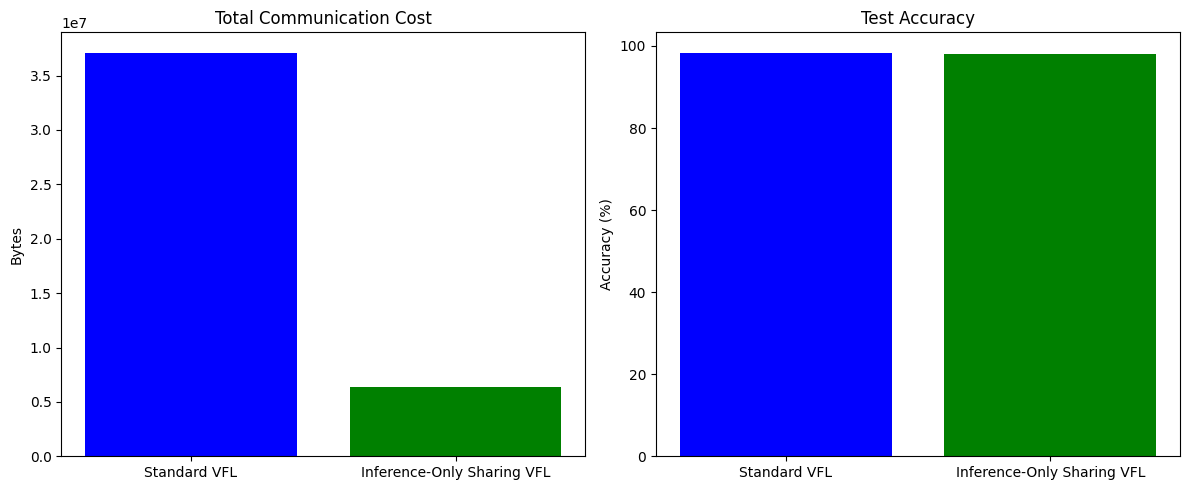


Running Inference on a Single Sample...
True Label: 1, Predicted Label: 1
Communication Cost for this Inference: 640 bytes

Running Inference on a Single Sample...
True Label: 3, Predicted Label: 3
Communication Cost for this Inference: 640 bytes

=== Summary ===
Inference-Only Sharing is more communication-efficient but may have slightly lower accuracy.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import time


SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

##############################################################################
# Dataset Definition (MNIST)
##############################################################################
class VerticalMNISTNParties(Dataset):
    """
    Splits each MNIST image (1,28,28) into N vertical slices.
    Returns (slice1, slice2, ..., sliceN, label).
    """
    def __init__(self, root, train=True, transform=None, download=True, num_parties=5):
        self.mnist = torchvision.datasets.MNIST(
            root=root,
            train=train,
            transform=transform,
            download=download
        )
        self.num_parties = num_parties

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        img, label = self.mnist[idx]
        slices = []
        columns_per_party = math.floor(28 / self.num_parties)

        start_col = 0
        for p in range(self.num_parties):
            if p < self.num_parties - 1:
                end_col = start_col + columns_per_party
            else:
                end_col = 28
            slice_i = img[:, :, start_col:end_col]
            slices.append(slice_i)
            start_col = end_col

        return (*slices, label)

##############################################################################
# Party Model (CNN -> Embedding)
##############################################################################
class PartyModel(nn.Module):
    """
    CNN-based PartyModel for processing local feature slices.
    """
    def __init__(self, input_channels=1, embedding_dim=32):
        super(PartyModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.adapt = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(32*7*7, embedding_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.adapt(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

##############################################################################
# Aggregator Model
##############################################################################
class AggregatorModel(nn.Module):
    """
    AggregatorModel that takes concatenated embeddings from all parties and outputs predictions.
    """
    def __init__(self, input_dim, hidden_dim=64, num_classes=10):
        super(AggregatorModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

##############################################################################
# Training Functions
##############################################################################
def train_party_models(party_models, train_loader, epochs=5, lr=0.01):
    """
    Train each PartyModel independently on its respective data slice.
    """
    for idx, party_model in enumerate(party_models):
        print(f"\nTraining PartyModel {idx + 1}/{len(party_models)}...")
        party_model.to(device)
        party_model.train()
        optimizer = torch.optim.SGD(party_model.parameters(), lr=lr, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(1, epochs + 1):
            total_loss = 0.0
            for batch_data in train_loader:
                *Xs, labels = batch_data
                inputs = Xs[idx].to(device)  #
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = party_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f"  Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}")

def train_standard_vfl(aggregator_model, party_models, train_loader, epochs=5, lr=0.01):
    """
    Train the AggregatorModel using embeddings shared during training (Standard VFL).
    """
    aggregator_model.to(device)
    aggregator_model.train()
    optimizer = torch.optim.SGD(aggregator_model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        for batch_data in train_loader:
            *Xs, labels = batch_data
            labels = labels.to(device)

            embeddings = []
            for party_model in party_models:
                inputs = Xs[party_models.index(party_model)].to(device)
                emb = party_model(inputs)
                embeddings.append(emb)

            combined = torch.cat(embeddings, dim=1)
            outputs = aggregator_model(combined)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"  AggregatorModel Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}")

def train_inference_only_vfl(aggregator_model, party_models, train_loader, epochs=5, lr=0.01):
    """
    Train the AggregatorModel using embeddings shared only during inference (Inference-Only Sharing).
    During training, embeddings are not shared; instead, the AggregatorModel is trained separately.
    """
    # First, train PartyModels independently
    train_party_models(party_models, train_loader, epochs=epochs, lr=lr)

    # Then, train AggregatorModel using the trained PartyModels (without updating PartyModels)
    aggregator_model.to(device)
    aggregator_model.train()
    optimizer = torch.optim.SGD(aggregator_model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        for batch_data in train_loader:
            *Xs, labels = batch_data
            labels = labels.to(device)

            embeddings = []
            for party_model in party_models:
                inputs = Xs[party_models.index(party_model)].to(device)
                with torch.no_grad():
                    emb = party_model(inputs)  # [N, embedding_dim]
                embeddings.append(emb)

            combined = torch.cat(embeddings, dim=1)  # [N, num_parties * embedding_dim]
            outputs = aggregator_model(combined)     # [N, num_classes]
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"  AggregatorModel Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}")

##############################################################################
# Evaluation Functions
##############################################################################
def evaluate_model(aggregator_model, party_models, test_loader, embedding_dim=32, num_parties=5, communication_during_training=0):
    """
    Evaluate the AggregatorModel on test data and calculate communication cost.


    """
    aggregator_model.to(device)
    aggregator_model.eval()
    for party_model in party_models:
        party_model.to(device)
        party_model.eval()

    correct = 0
    total = 0
    total_bytes = communication_during_training  # Initialize with training communication

    float_size = 4  # bytes

    with torch.no_grad():
        for batch_idx, batch_data in enumerate(test_loader):
            *Xs, labels = batch_data
            labels = labels.to(device)

            embeddings = []
            for i, party_model in enumerate(party_models):
                inputs = Xs[i].to(device)
                emb = party_model(inputs)  # [N, embedding_dim]
                embeddings.append(emb)

            combined = torch.cat(embeddings, dim=1)  # [N, num_parties * embedding_dim]
            outputs = aggregator_model(combined)     # [N, num_classes]
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Calculate communication cost for inference
            batch_size = labels.size(0)
            total_floats = num_parties * embedding_dim * batch_size
            total_bytes += total_floats * float_size

    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Total Communication Cost: {total_bytes} bytes")
    print(f"Average Communication per Sample: {total_bytes / total:.2f} bytes")
    return accuracy, total_bytes

def run_single_sample_inference(aggregator_model, party_models, test_loader, embedding_dim=32, num_parties=5):
    """
    Perform inference on a single sample and report communication cost.


    """
    print("\nRunning Inference on a Single Sample...")
    sample_loader = DataLoader(test_loader.dataset, batch_size=1, shuffle=True)
    *slices, label = next(iter(sample_loader))
    label = label.to(device)

    embeddings = []
    for i, party_model in enumerate(party_models):
        inputs = slices[i].to(device)
        emb = party_model(inputs)
        embeddings.append(emb)

    combined = torch.cat(embeddings, dim=1)
    combined = combined.to(device)
    aggregator_model.eval()
    with torch.no_grad():
        output = aggregator_model(combined)
        _, predicted = torch.max(output, 1)

    # Calculate communication cost for single sample
    float_size = 4
    total_floats = num_parties * embedding_dim
    total_bytes = total_floats * float_size

    print(f"True Label: {label.item()}, Predicted Label: {predicted.item()}")
    print(f"Communication Cost for this Inference: {total_bytes} bytes")

##############################################################################
# Main Function
##############################################################################
def main():
    """
    Main function to train and evaluate both Standard VFL and Inference-Only Sharing.
    """
    num_parties = 5
    embedding_dim = 32
    party_epochs = 5
    aggregator_epochs = 5
    batch_size = 64
    lr = 0.01

    # 1. Prepare Data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    full_train_data = VerticalMNISTNParties(
        root='./data',
        train=True,
        transform=transform,
        download=True,
        num_parties=num_parties
    )
    test_data = VerticalMNISTNParties(
        root='./data',
        train=False,
        transform=transform,
        download=True,
        num_parties=num_parties
    )

    # Create a validation split (20% of training for validation)
    train_size = int(len(full_train_data) * 0.8)
    valid_size = len(full_train_data) - train_size
    train_data, valid_data = random_split(full_train_data, [train_size, valid_size])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

    # 2. Initialize PartyModels for Standard VFL
    standard_party_models = []
    for p in range(num_parties):
        party_model = PartyModel(input_channels=1, embedding_dim=embedding_dim)
        standard_party_models.append(party_model)
    print(f"\nInitialized {num_parties} PartyModels for Standard VFL with embedding_dim={embedding_dim}")

    # 3. Initialize PartyModels for Inference-Only Sharing
    inference_party_models = []
    for p in range(num_parties):
        party_model = PartyModel(input_channels=1, embedding_dim=embedding_dim)
        inference_party_models.append(party_model)
    print(f"\nInitialized {num_parties} PartyModels for Inference-Only Sharing VFL with embedding_dim={embedding_dim}")

    # 4. Initialize AggregatorModels
    standard_aggregator = AggregatorModel(input_dim=num_parties * embedding_dim, hidden_dim=64, num_classes=10)
    inference_aggregator = AggregatorModel(input_dim=num_parties * embedding_dim, hidden_dim=64, num_classes=10)
    print("\nInitialized AggregatorModels for both methods.")

    # 5. Train Standard VFL
    print("\n=== Training Standard VFL ===")
    start_time = time.time()
    train_party_models(standard_party_models, train_loader, epochs=party_epochs, lr=lr)
    train_standard_vfl(standard_aggregator, standard_party_models, train_loader, epochs=aggregator_epochs, lr=lr)
    standard_training_time = time.time() - start_time
    print(f"Standard VFL Training Time: {standard_training_time:.2f} seconds")

    # 6. Train Inference-Only Sharing VFL
    print("\n=== Training Inference-Only Sharing VFL ===")
    start_time = time.time()
    train_inference_only_vfl(inference_aggregator, inference_party_models, train_loader, epochs=aggregator_epochs, lr=lr)
    inference_training_time = time.time() - start_time
    print(f"Inference-Only Sharing VFL Training Time: {inference_training_time:.2f} seconds")

    # 7. Evaluate Standard VFL
    print("\n=== Evaluating Standard VFL ===")
    standard_accuracy, standard_comm = evaluate_model(standard_aggregator, standard_party_models, test_loader, embedding_dim, num_parties, communication_during_training=num_parties * embedding_dim * len(train_loader.dataset) * 4)  # Approximation

    # 8. Evaluate Inference-Only Sharing VFL
    print("\n=== Evaluating Inference-Only Sharing VFL ===")
    inference_accuracy, inference_comm = evaluate_model(inference_aggregator, inference_party_models, test_loader, embedding_dim, num_parties)

    # 9. Compare Communication Efficiency
    print("\n=== Communication Efficiency Comparison ===")
    print(f"Standard VFL - Total Communication: {standard_comm} bytes, Accuracy: {standard_accuracy:.2f}%")
    print(f"Inference-Only Sharing VFL - Total Communication: {inference_comm} bytes, Accuracy: {inference_accuracy:.2f}%")

    # 10. Plot Communication Costs
    methods = ['Standard VFL', 'Inference-Only Sharing VFL']
    communication_costs = [standard_comm, inference_comm]
    accuracies = [standard_accuracy, inference_accuracy]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Communication Cost
    axs[0].bar(methods, communication_costs, color=['blue', 'green'])
    axs[0].set_title('Total Communication Cost')
    axs[0].set_ylabel('Bytes')

    # Plot Accuracy
    axs[1].bar(methods, accuracies, color=['blue', 'green'])
    axs[1].set_title('Test Accuracy')
    axs[1].set_ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()


    run_single_sample_inference(inference_aggregator, inference_party_models, test_loader, embedding_dim, num_parties)


    run_single_sample_inference(standard_aggregator, standard_party_models, test_loader, embedding_dim, num_parties)


    print("\n=== Summary ===")
    if inference_comm < standard_comm and inference_accuracy >= standard_accuracy:
        print("Inference-Only Sharing is more communication-efficient without sacrificing accuracy.")
    elif inference_comm < standard_comm and inference_accuracy < standard_accuracy:
        print("Inference-Only Sharing is more communication-efficient but may have slightly lower accuracy.")
    else:
        print("Inference-Only Sharing does not offer communication efficiency benefits over Standard VFL in this setup.")

if __name__ == "__main__":
    main()
